In [2]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF

import Bgolearn.BGOsampling as BGOS 

 Bgolearn : A Bayesian global optimization package 
 10 Jul 2022, version 1, Bin Cao, MGI, SHU, Shanghai, CHINA.


In [3]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [4]:
def generate_function(data, obs):
    print('------------12 original data-----------')
    data = np.array(data)
    # for one feature dataset
    data_matrix = np.array(data[:,0]).reshape(-1, 1)

    Measured_response = np.zeros(len(data_matrix))
    for i in range(obs):
        Measured_response += np.array(data[:,i+1])
    # for one feature dataset
    Measured_response = Measured_response/obs
    
    Measured_std = []
    for j in range(len(data_matrix)):
        std = np.std(np.array(data[j,1:1+obs]))
        Measured_std.append(std)
    Measured_std = np.array(Measured_std)  
    print('evaluated mean of y :', Measured_response)
    print('evaluated std of y :', Measured_std)
    print('---------------------------------------\n')
    return data_matrix,Measured_response,Measured_std

## design virtual samples

In [5]:
virtual_samples = np.linspace(0,11,111)

In [6]:
virtual_samples

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. ])

## define a  sampling function

In [7]:
def Sam_function(X,real_std,obs):
    print('--------------Draw samples-------------')
    print('real std of added datum:', real_std)
    X = np.array(X)
    Y = np.zeros(1)
    Y_obs = []
    for i in range(obs):
        __sam = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=real_std, size=None)
        Y_obs.append(__sam)
        Y += __sam
        print(i+1,'-th sampling, result = ', __sam)
    cal_std = np.std(np.array(Y_obs))
    print('evaluated mean of added datum:', Y/obs)
    print('evaluated std of added datum:', cal_std)
    print('---------------------------------------\n')
    return Y/obs, np.array(cal_std), np.array(Y_obs)


# heterogeneous noise


In [8]:
# instantiate Bgolearn
Bgolearn = BGOS.Bgolearn()
method_name = 'KG'

obs = 5
tolerance = 0.05
guessed_noise_std = 'hetero'

------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

The internal model is instantiated with heterogenous noise
The 2000-th Monte carol simulation
The 4000-th Monte carol simulation
The next datum recomended by Knowledge Gradient : 
 x =  [8.4]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.8619736080569145
2 -th sampling, result =  3.8196576125765316
3 -th sampling, result =  3.9675560925269804
4 -th sampling, result =  3.863819140607792
5 -th sampling, result =  3.7274312256328885
evaluated mean of added datum: [3.84808754]
evaluated std of added datum: 0.07756190837855273
---------------------------

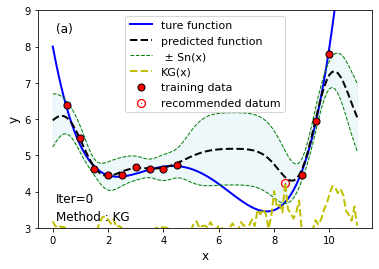

The internal model is instantiated with heterogenous noise
The 2000-th Monte carol simulation


In [ ]:
sort_ab=('a','b','c','d','e','f','g','h','i','j','k','l','m','n')

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
cal_name = data.columns[1:]
response_array = copy.deepcopy(Measured_response)

recom_x = []   
recom_obs = []
recom_real_std = []
recom_estimate_mu = []
recom_estimate_std = []
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
    y_mean_pre,y_mean_std = GaussianProcessRegressor(kernel=RBF(),normalize_y=True,alpha = Measured_std).fit(data_matrix, Measured_response).predict(virtual_samples.reshape(-1,1),return_std=True) 
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(data_matrix,Measured_response,virtual_samples,noise_std = Measured_std,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.Knowledge_G(MC_num=50)*10+3
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.max()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    datum_y, datum_std, Y_obs = Sam_function(recommend,0.3,obs)
    
    recom_x.append(recommend)
    # Y_obs is the sampling results, array type
    recom_obs.append(Y_obs) 
    recom_estimate_mu.append(datum_y)
    recom_estimate_std.append(datum_std)
    
    Measured_std = np.append(Measured_std,datum_std)
    
    
    data_matrix = np.append(data_matrix,recommend).reshape(-1,1)
    Measured_response = np.append(Measured_response,datum_y)
 
    
    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',(recommend,datum_y))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
   
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.text(0.1,8.4,'({})'.format(sort_ab[i]),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11,loc='upper center')
    plt.savefig('fixnoise_{name}-sd_{sdlevel}-obs_{obstime}-{num}.png'.format(name = method_name,sdlevel=guessed_noise_std,obstime = obs,num = i),dpi=800)
    plt.savefig('fixnoise_{name}-sd_{sdlevel}-obs_{obstime}-{num}.svg'.format(name = method_name,sdlevel=guessed_noise_std,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if  abs(datum_y - response_array[-1]) / response_array[-1] <= tolerance:
        print('last response = ',response_array[-1])
        print('added datum y = ',datum_y, ', attached the coverge criteia')
        recom_dataset = pd.DataFrame(np.array(recom_obs))
        recom_dataset.columns = cal_name
        recom_dataset.insert(loc = 0, column = 'x', value = np.array(recom_x))
        recom_dataset.insert(loc = 1, column = 'true_y', value = True_function(np.array(recom_x)))
        recom_dataset['estimated_mu'] = np.array(recom_estimate_mu)
        recom_dataset['estimated_std'] = np.array(recom_estimate_std)
        break
    elif i>=10:
        print('Searching is defeated')
        recom_dataset = pd.DataFrame(np.array(recom_obs))
        recom_dataset.columns = cal_name
        recom_dataset.insert(loc = 0, column = 'x', value = np.array(recom_x))
        recom_dataset.insert(loc = 1, column = 'true_y', value = True_function(np.array(recom_x)))
        recom_dataset['estimated_mu'] = np.array(recom_estimate_mu)
        recom_dataset['estimated_std'] = np.array(recom_estimate_std)
        break
    else:
        response_array = np.append(response_array,datum_y)
        

recom_dataset.to_csv('fixnoise{noise}_iter{time}data.csv'.format(noise=guessed_noise_std, time = i+1),float_format='%.4f') 